## qPCR analysis

*Does developmental temperature impact expression of genes that dictate metamorphosis timing in fruit flies?*

## Goal

*The goal of this project is to use Python to analyse and visualize the results of a qPCR I performed during my PhD in Biology*

## Experiment description

*D. melanogaster pupa, developed at either 18 or 25C, had its RNA extracted with Trizol at 30, 50 and 80% of development. RNA was retrotranscribed into cDNA and used for the qPCR reaction* 

* Gene expression was evaluated for three genes in the ecdysone pathway: BLIMP1, HR3 and e75.
* As housekeeping / endogenous genes (controls) it was used actin, RPL15, GADPH.
* Experiment was done in technical triplicate

For fruit flies, pupa development at 18C takes 2.2 times longer than at 25C. Therefore, time points were chosen at the same relative developmental rate for both conditions. 
* Flies developed at 25C: 25 30h, 25C 55h and 25C 80h
* Flies developed at 18C: 18C 66h, 18C 121h and 18C 176h. 

## Setup

#### Importing the necessary libraries I will use for this project

In [57]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import seaborn as sns

#### Reading the data

In [58]:
df = pd.read_csv('qPCR_ecdysone_all_genes_raw.csv')

#### Looking at the data

In [59]:
df.head()

,Well,Omit,Sample,Target,Task,Dyes,Cq,Cq Conf,Amp Score,Amp Status,Annotated,Threshold,Baseline Start,Baseline End,Tm1,Tm2,Tm3,Tm4,Curve Quality,Result Quality Issues
0,A1,False,2530,GAPDH,Unknown,SYBR,20.947729156200793,0.990117,2.825785,Amp,False,98309.513955,3,11,85.026268,NaN,NaN,NaN,NaN,NaN
1,A2,False,2530,GAPDH,Unknown,SYBR,20.835758885163173,0.990180,2.835256,Amp,False,98309.513955,3,11,85.026268,NaN,NaN,NaN,NaN,NaN
2,A3,False,2530,GAPDH,Unknown,SYBR,20.965280845811115,0.990545,2.820061,Amp,False,98309.513955,3,12,85.026268,NaN,NaN,NaN,NaN,NaN
3,A5,False,2530,RPL,Unknown,SYBR,16.007318699234727,0.987557,2.823787,Amp,False,77860.662866,3,7,82.887802,NaN,NaN,NaN,NaN,NaN
4,A6,False,2530,RPL,Unknown,SYBR,16.198816859391513,0.985226,2.781106,Amp,False,77860.662866,3,7,83.000549,NaN,NaN,NaN,NaN,NaN


The important information here are in the columns 'Sample', 'Target' and 'Cq'. 
* Sample: we have the biological identitiy of our cDNA - from which temperature/time point it comes from. 
* Target: indicates which gene we are evaluating the expression
* Cq (usually known as Ct): is an indicator of how much cDNA for the target gene is present. If there is no cDNA, this number is going to be high (30-35). 

Lets see which treatments we have:

In [60]:
print(df['Sample'].unique())

['2530' '2555' '2580' 'NO DNA' '1866' '18121' '18176']


We see the three time points for each developmental temperature as expected. However, we also have a 'NO (c)DNA' sample, which was used as a negative control, to make sure there was no unintended extension. Let's take a quick look at the Ct values for the negative control on our house keeping gene, RPL.

In [61]:
neg_control = df.loc[(df['Sample'] == 'NO DNA') & (df['Target'] == 'RPL')]
neg_control

,Well,Omit,Sample,Target,Task,Dyes,Cq,Cq Conf,Amp Score,Amp Status,Annotated,Threshold,Baseline Start,Baseline End,Tm1,Tm2,Tm3,Tm4,Curve Quality,Result Quality Issues
57,F5,False,NO DNA,RPL,Unknown,SYBR,Undetermined,0.0,NaN,No Amp,False,77860.662866,3,39,83.226028,89.539658,75.559486,80.520187,NaN,NaN
58,F6,False,NO DNA,RPL,Unknown,SYBR,Undetermined,0.0,NaN,No Amp,False,77860.662866,3,39,89.088684,71.951698,85.142670,82.662315,NaN,NaN
59,F7,False,NO DNA,RPL,Unknown,SYBR,Undetermined,0.0,1.336761,No Amp,False,77860.662866,3,39,89.426918,82.887802,86.044617,92.921967,NaN,NaN


The Ct value is undetermined, indicating there was no reaction and therefore the negative control is working. We can then clean and analyse this data :) 

In [62]:
# keep only the important columns
data_cq = df[['Sample', 'Target', 'Cq']]
data_cq.tail() 

,Sample,Target,Cq
142,2555,HR3,19.67391215034211
143,2555,HR3,19.76051933342125
144,18121,HR3,19.196955168606053
145,18121,HR3,19.202696825692186
146,18121,HR3,19.096282584597525


In [63]:
# remove the negative control 
data = data_cq.loc[(data_cq['Sample'] != 'NO DNA')]
# check if 'no DNA' is gone 
print(data['Sample'].unique())

['2530' '2555' '2580' '1866' '18121' '18176']


For the analysis we need the following computations, which will be added to a new column. For comparing the fold change in expression, we need a 'reference' sample (no treatment, in our case the first time point of 25C). This reference will be used for normalization.

In [64]:
ref_table = pd.DataFrame()
reference = '2530'

#gets mean delta ct 
ref = data.loc[(data['Sample'] == reference)]
for tar in ref['Target'].unique():
   #mean delta delta CT should be in relation to the CT value of 2530 for that gene
   ref_tar = ref.loc[(ref['Target'] == tar)]
   ref_rpl = ref.loc[(ref['Target']=='RPL')]

   #calculates delta ct of gene in relation to RPL
   #ref RPL mean
   ref_tar['rpl_mean'] = np.mean(pd.to_numeric(ref_rpl['Cq']))
   ref_tar['delta_ct'] = pd.to_numeric(ref_tar['Cq']) - ref_tar['rpl_mean']
   ref_tar['mean_delta_ct'] = np.mean(ref_tar['delta_ct'])
   ref_table = pd.concat([ref_table, ref_tar])

With that, we can do the quantification of the other samples and other genes, relative to our reference and save the results as a csv file

In [65]:
genes_table = pd.DataFrame()
results_table = pd.DataFrame()

for i in data['Sample'].unique():
   #print(i)
   df = data.loc[(data['Sample'] == i)]
   rpl = df.loc[(df['Target']=='RPL')]
   df['rpl_mean'] = np.mean(pd.to_numeric(rpl['Cq']))

   for tar in df['Target'].unique():
      #print(tar)
      gene = df.loc[(df['Target'] == tar)]
      gene['delta_ct'] = pd.to_numeric(df['Cq']) - df['rpl_mean']
      gene['mean_delta_ct'] = np.mean(gene['delta_ct'])
      ref_mdct = ref_table.loc[(ref_table['Target'] == tar)]
      ref_mdct_u = ref_mdct['mean_delta_ct'].mean()
      gene['delta_delta_ct'] = gene['delta_ct'] - ref_mdct_u 
      gene['fold_change'] = np.power(2, -gene['delta_delta_ct'])
      gene['mean_foldchange'] = np.mean(gene['fold_change'])
      genes_table = pd.concat([genes_table, gene])

results_table = pd.concat([results_table, genes_table])

results_table.to_csv('results.csv')




## Plotting results

Adding a temperature and timepoint column

In [66]:
results_table['temp'] = results_table['Sample'].str[0:2]

# for the same relative develop. percentage for 18 and 25
ids = {'1866': '30%', '18176': '55%', '18121': '80%', 
       '2530': '30%', '2555': '55%', '2580': '80%'}

for old, new in ids.items():
   results_table['Sample'] = results_table['Sample'].str.replace(old, new, regex=True)

results_table['Sample'].unique()

array(['30%', '55%', '80%'], dtype=object)

Fold change for control genes 

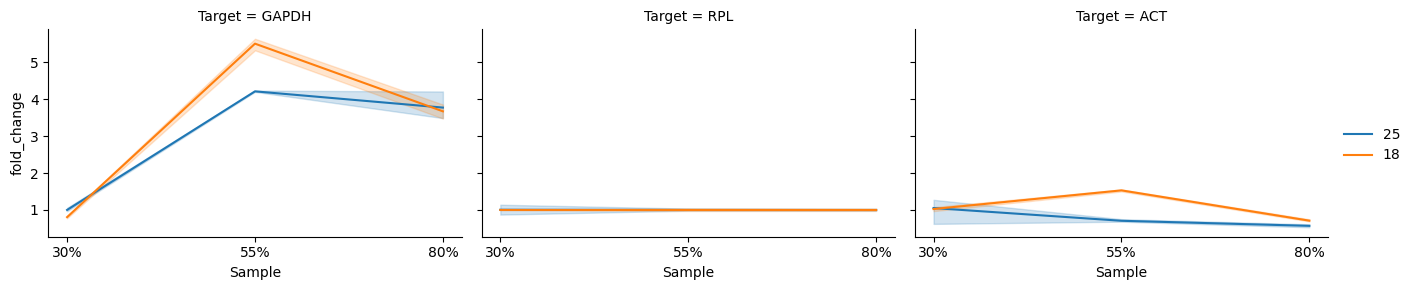

In [67]:
controls = results_table.loc[results_table['Target'].isin(['ACT','GAPDH', 'RPL'])]
ct = sns.FacetGrid(controls, col="Target", col_wrap=3, aspect=1.5)
ct.map(sns.lineplot,"Sample","fold_change","temp")
ct.add_legend()

Since GAPDH is a metabolic gene, this high fold change might indicate that flies developed at different temperatures present a different metabolism level. 

Fold change of test genes (separated by temperature)

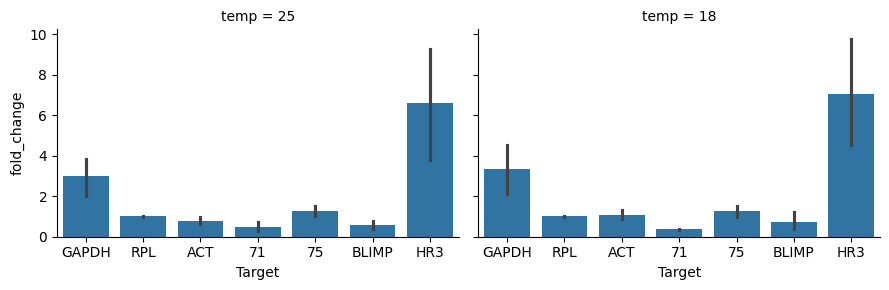

In [47]:
general = sns.FacetGrid(results_table, col="temp", col_wrap=2, aspect=1.5)
general.map(sns.barplot,"Target","fold_change", order = results_table['Target'])

As HR3 has a high fold change, I'll choose to look at it separately. 

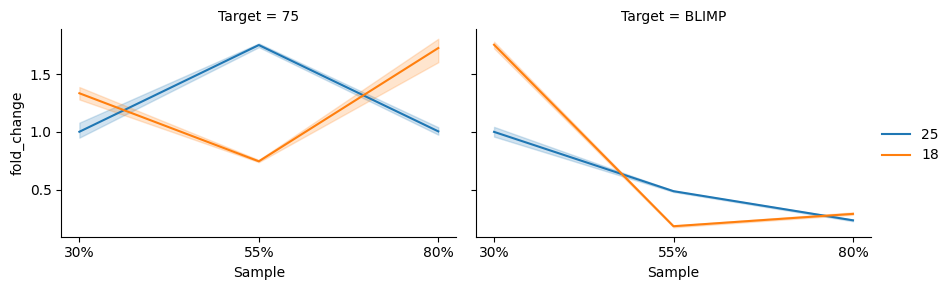

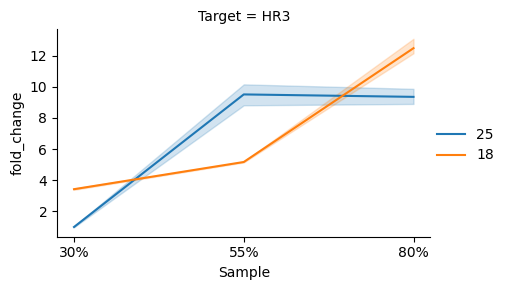

In [41]:
test_genes = results_table.loc[results_table['Target'].isin(['BLIMP','75'])]
g = sns.FacetGrid(test_genes, col="Target", col_wrap=2, aspect=1.5)
g.map(sns.lineplot,"Sample","fold_change","temp")
g.add_legend()

hr3 = results_table.loc[results_table['Target'].isin(['HR3'])]
hr = sns.FacetGrid(hr3, col="Target", col_wrap=1, aspect=1.5)
hr.map(sns.lineplot,"Sample","fold_change","temp")
hr.add_legend()